# Find and remove duplicate images with FiftyOne

Duplicate images in a train or test set can lead to your model learning biases that will impact its ability to generalize to new data. The problem is that large image datasets are difficult to examine so manually finding duplicates can be expensive.

This notebook with guide you through how to find and remove duplicates in your data by:

* Loading your data into FiftyOne

* Computing embeddings for your images with the FiftyOne model zoo

* Calculating the similarity of your images

* Visualizing and automatically removing duplicates

## Setup

Run the following lines to install FiftyOne, Scikit Learn, and PyTorch (to generate embeddings)

In [ ]:
!pip install fiftyone

In [ ]:
!pip install torch torchvision

In [ ]:
!pip install sklearn

## Loading your data

In this example, we will be using the image classification dataset, CIFAR100. This dataset is fairly old (2009) but still relevant enough that papers submitted to ICLR 2021 are using it as a baseline.

CIFAR-100 contains 60,000 images between the train and test split annotated with 100 label classes grouped into 20 "super classes". This dataset also exists in the FiftyOne dataset zoo and can be easily loaded.

In [1]:
import fiftyone as fo
import fiftyone.zoo as foz

In [ ]:
# This will download all 60,000 samples
dataset = foz.load_zoo_dataset("cifar100")


# If you are running this notebook on a machine without a GPU or want it to run quickly, uncomment the line below

# dataset = foz.load_zoo_dataset("cifar100", shuffle=True, max_samples=1000)

## Generate Embeddings

Images store a lot of information in their pixel values. Comparing images pixel-by-pixel would be an expensive operation and result in poor quality results. 

Instead, we can use a pretrained computer vision model to generate embeddings for each image. An embedding is a result of processing an image through a deep model into the form of a vector containing a few thousand values distilling the information stored in the millions of pixels.

The FiftyOne model zoo contains a host of different pretrained models that we can use for this task. In this example, we will use MobileNet trained to classify images on the ImageNet dataset. This model provides relatively high performance, but most importantly is lightweight and can process our dataset quicker than other models. 

Selecting a model with the highest performance is not as important for this task since we are not using its final predictions, only the features generated by the model.

We can easily load the model and compute embeddings on our dataset.

In [ ]:
model = foz.load_zoo_model("mobilenet-v2-imagenet-torch")

In [75]:
embeddings = dataset.compute_embeddings(model)

print(embeddings.shape)

(60000, 1280)


## Calculate Similarity

Now that we have significantly reduced the dimensionality of our images, we can use classical similarity algorithms to compute how similar every image embedding is to every other image embedding.

In this case, we will use cosine similarity provided by Scikit Learn since this algorithm is simple and works fairly well in high dimensional spaces.

In [43]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [44]:
similarity_matrix = cosine_similarity(embeddings)

print(similarity_matrix.shape)
print(similarity_matrix)

(60000, 60000)
[[1.         0.66108999 0.68013095 ... 0.66358586 0.58341951 0.72003263]
 [0.66108999 1.         0.6504253  ... 0.5211634  0.56383594 0.62717584]
 [0.68013095 0.6504253  1.         ... 0.60735498 0.50470889 0.67887746]
 ...
 [0.66358586 0.5211634  0.60735498 ... 1.         0.46415098 0.54793259]
 [0.58341951 0.56383594 0.50470889 ... 0.46415098 1.         0.56771587]
 [0.72003263 0.62717584 0.67887746 ... 0.54793259 0.56771587 1.        ]]


As you can see, all diagonal values are 1 since every image is identical to itself. We can subtract by the identity matrix (N x N matrix with 1's on the diagonal and 0's elsewhere) in order to zero out the diagonal so those values don't show up when we look for samples with maximum similarity.

In [45]:
n = len(similarity_matrix)

similarity_matrix = similarity_matrix - np.identity(n)

**Note:** Computing cosine similarity on datasets with more than 100,000 images can time and memory intensive. It is recommended to split the embeddings into batches and parallelize the process to speed up this computation.

## Visualize and remove duplicates

We can now iterate through every sample and find which other samples are the most similar to it.






In [ ]:
id_map = [s.id for s in dataset.select_fields(["id"])]

for idx, sample in enumerate(dataset):
    sample["max_similarity"] = similarity_matrix[idx].max()
    sample.save()

The FiftyOne App allows us to visualize and explore our dataset right in this notebook.


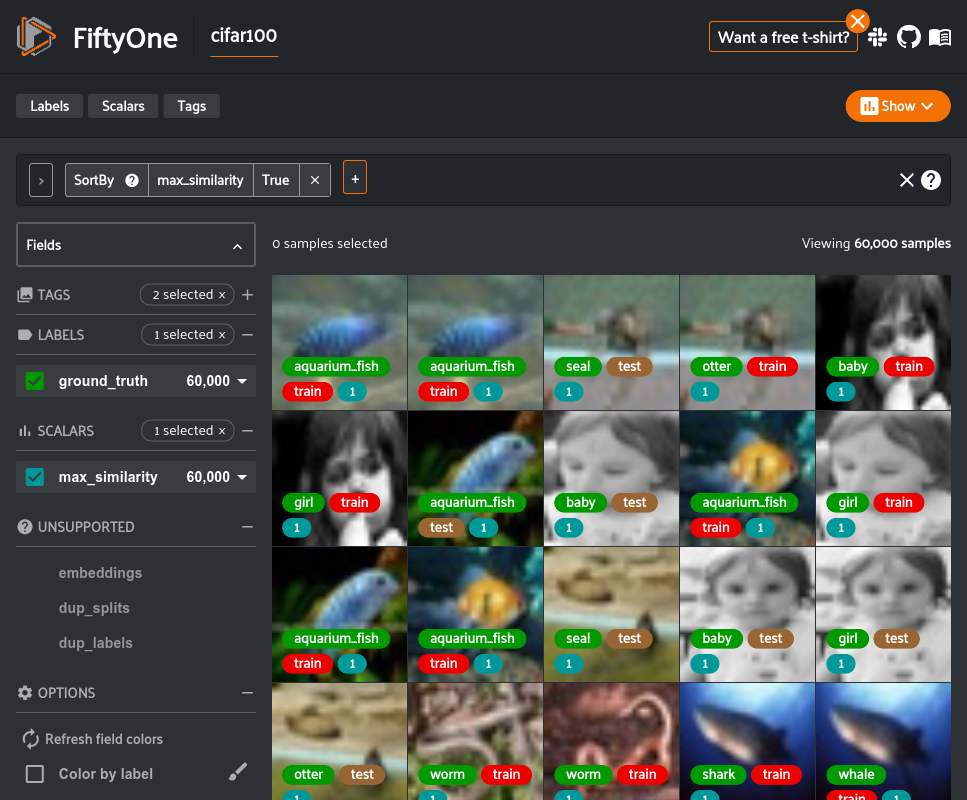


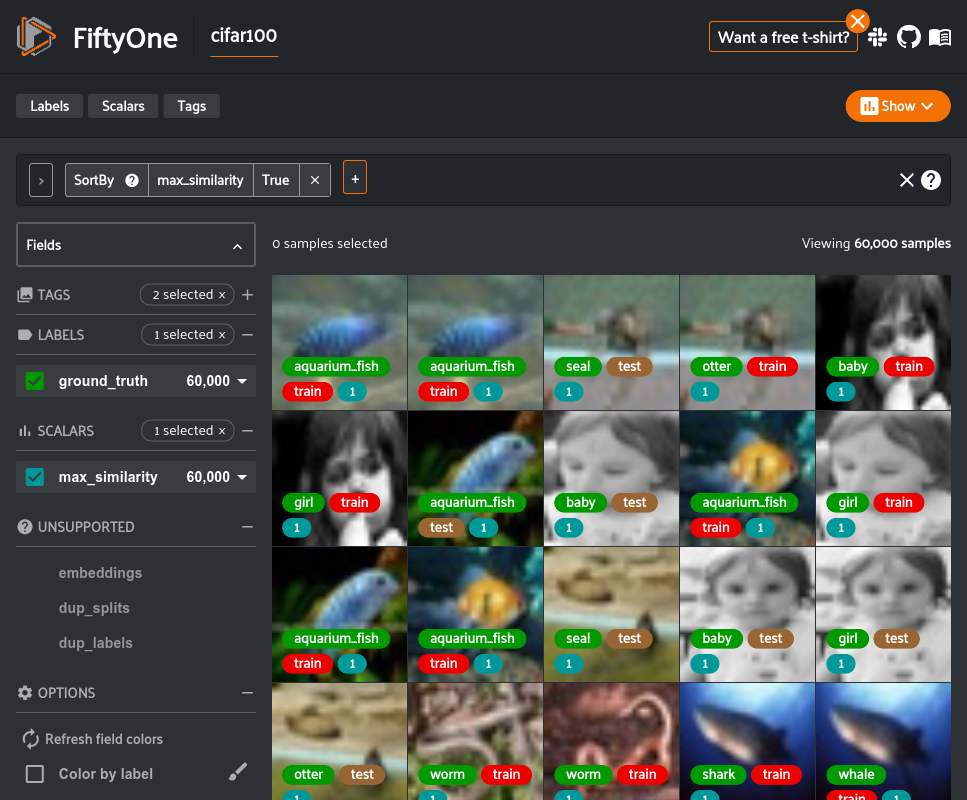

In [40]:
session = fo.launch_app(dataset)



Visualizing the results and sorting by the samples with the highest similarity shows us the duplicates in the dataset. 

Right off the bat, we can see a lot of duplicates and something even more problematic. Two of the images are duplicates but one is in the train split and one is in the test split…. and they are labeled differently as seal vs otter!!! There are so many things wrong with this:
* It can be both a seal and an otter so one of the labels is wrong
* If the model is trained on it, you shouldn't test it on the same image
* Providing different labels for the train and test versions of the image will undoubtedly cause the model to fail

By looking through the results, we can find a threshold that we can use as a cutoff for when two images are determined to be duplicated. This threshold will be different for every dataset/model used in this process so the visualization step is crucial.

Further inspection puts a good threshold for guaranteed duplicates around 0.92. Lower values likely also include duplicates but should be verified manually so that we do not remove useful data. We can filter the dataset through code as well to see just how many samples have a max_similarity of > 0.92.

In [9]:
from fiftyone import ViewField as F

dataset.match(F("max_similarity")>0.92)

Dataset:        cifar100-similarity
Media type:     image
Num samples:    4345
Tags:           ['test', 'train']
Sample fields:
    filepath:       fiftyone.core.fields.StringField
    tags:           fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:       fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth:   fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    max_similarity: fiftyone.core.fields.FloatField
    embeddings:     fiftyone.core.fields.VectorField
View stages:
    1. Match(filter={'$expr': {'$gt': [...]}})

4345 out of 60,000 samples are conservatively marked as duplicates!

Let's use a threshold of 0.92 and tag all duplicate samples. This is where you would remove them if so desired.

In [50]:
id_map = [s.id for s in dataset.select_fields(["id"])]

In [33]:
thresh = 0.92
samples_to_remove = set()
samples_to_keep = set()

for idx, sample in enumerate(dataset):
    if sample.id not in samples_to_remove:
        # Keep the first instance of two duplicates
        samples_to_keep.add(sample.id)
        
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        for dup in dup_idxs:
            # We kept the first instance so remove all other duplicates
            samples_to_remove.add(id_map[dup])
        if len(dup_idxs) > 0:
            sample.tags.append("has_duplicates")
            sample.save()
        
    else:
        sample.tags.append("duplicate")
        sample.save()
        
print(len(samples_to_remove) + len(samples_to_keep))

            
# If you want to remove the samples from the dataset entirely, uncomment the following line
# dataset.remove_samples(list(samples_to_remove))

60000



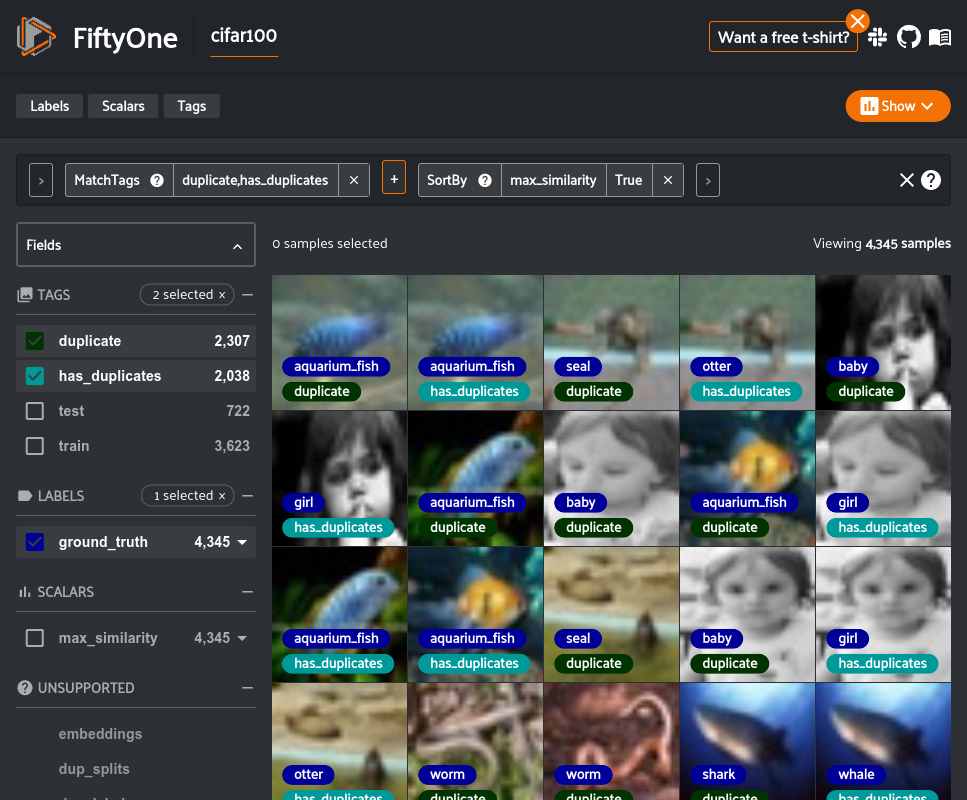


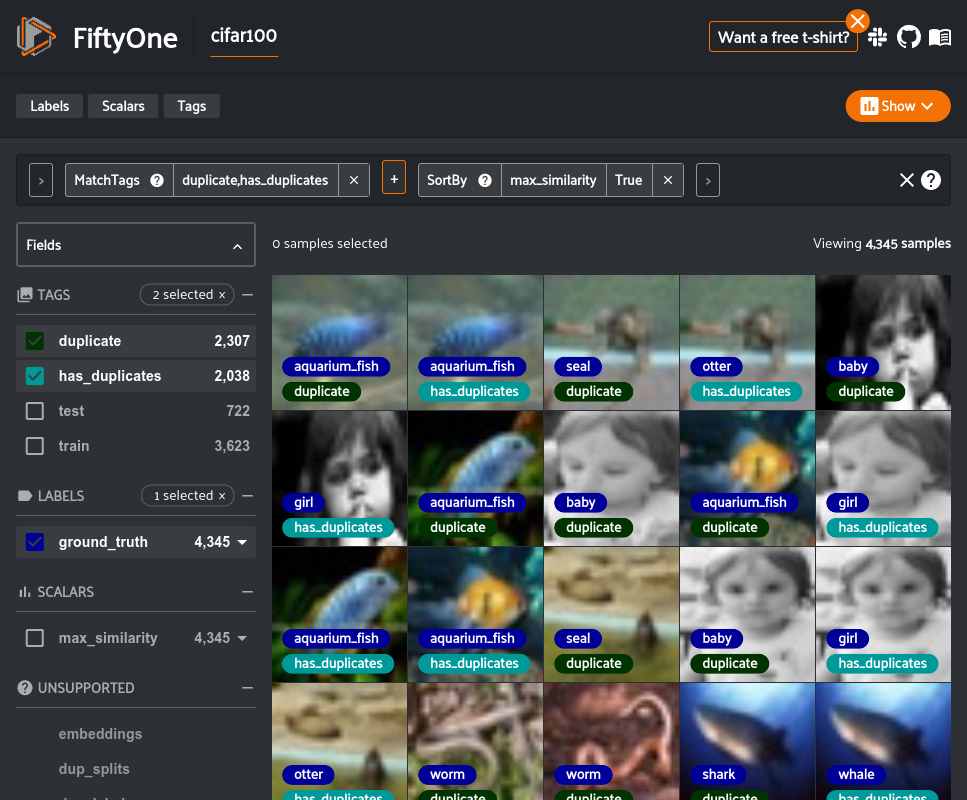

In [41]:
session.show()

Let's see how many of these samples have duplicates both in the test and train split and how many are labeled differently.

In [54]:
view = dataset.match_tags(["has_duplicates","duplicate"])
thresh = 0.92

for idx, sample in enumerate(dataset):
    if sample.id in view:
        dup_idxs = np.where(similarity_matrix[idx] > thresh)[0]
        dup_splits = []
        dup_labels = []
        for dup in dup_idxs:
            dup_sample = dataset[id_map[dup]]
            dup_split = "test" if "test" in dup_sample.tags else "train"
            dup_splits.append(dup_split)
            dup_labels.append(dup_sample.ground_truth.label)
        
        sample["dup_splits"] = dup_splits
        sample["dup_labels"] = dup_labels
        sample.save()

In [47]:
session.view = view

In [55]:
view.first()

<SampleView: {
    'id': '6011d3954a922e0449a614d1',
    'media_type': 'image',
    'filepath': '/home/erich/fiftyone/cifar100/train/data/000008.jpg',
    'tags': BaseList(['train', 'has_duplicates']),
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '6011d3954a922e0449a614d0',
        'label': 'cup',
        'confidence': None,
        'logits': None,
    }>,
    'max_similarity': 0.934310956080192,
    'embeddings': array([0.53727144, 0.36267596, 0.54651034, ..., 0.56505048, 0.08496355,
           0.68984002]),
    'dup_splits': BaseList(['train']),
    'dup_labels': BaseList(['cup']),
}>

In [56]:
from fiftyone import ViewField as F

Compute how many of the duplicates exist in BOTH the train and test split.

In [61]:
train_w_test_dups = len(view
    .match(F("tags").contains("train"))
    .match(F("dup_splits").contains("test"))
)

test_w_train_dups = len(view
    .match(F("tags").contains("test"))
    .match(F("dup_splits").contains("train"))
)

print(train_w_test_dups + test_w_train_dups)

1621


## (Optional) Find unique images

FiftyOne also provides the ability to compute the uniqueness of every image in a dataset. This will result in a score for every image indicating how unique the contents of the image are with respect to all other images.

We have a way of finding duplicate images in a dataset, but with uniqueness, we are able to find images that may not be duplicated but contain features that already exist in other samples in the dataset.

Uniqueness can be helpful when deciding which samples to send to annotators. If you are only going to spend money to get the best subset of your data annotated, then you will want the most unique samples to train/test your model on.

In [76]:
import fiftyone.brain as fob

In [ ]:
# It is not recommened to run this on the 60,000 image dataset as it takes quite some time

fob.compute_uniqueness(dataset)

Loading uniqueness model...
 100%   100.6Mb/100.6Mb [1.4s elapsed, 0s remaining, 85.0Mb/s]      
Preparing data...


/home/erich/sw/conda/envs/cam1/lib/python3.7/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


Generating embeddings...
 100%  60000/60000 [1.3m elapsed, 0s remaining, 721.9 samples/s]    
Computing uniqueness...
